In [1]:
import pandas as pd
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import gpytorch
from Clean import Clean
import time

%matplotlib inline

# Data Prep

In [2]:
n = 100

df = pd.read_csv('FM_2000-2019.csv')
print(df.shape)
df_all = df[df['gp_all_0_a'] >= 30]
df = df_all[0:n]
df_star = df_all[-n:]
print(df.shape)
print(df_star.shape)

(24171, 459)
(100, 459)
(100, 459)


In [3]:
games = 30
q = 1

clean = Clean(df,games)
features = clean.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y = clean.get_target(q).values
cols = features.columns
x = features.values
print(x.shape, y.shape)

clean_test = Clean(df_star,games)
features_test = clean_test.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y_star = clean_test.get_target(q).values
cols_test = features_test.columns
x_star = features_test.values
print(x_star.shape, y_star.shape)

(90, 24) (90,)
(100, 24) (100,)


# Fit a Gaussian process (PyMC3)

In [34]:
with pm.Model() as model:
    a = pm.HalfCauchy('a', beta=1)
    # ls = pm.Normal('ls', mu=0, sigma=1, shape=x.shape[1])
    # ls = pm.HalfNormal('ls', sigma=1, shape=x.shape[1])
    ls = pm.Gamma('ls', alpha=4, beta=3, shape=x.shape[1])
    cov = a**2 * pm.gp.cov.ExpQuad(input_dim=x.shape[1], ls=ls)
    gp = pm.gp.Marginal(cov_func=cov)

    
    noise = pm.HalfNormal('noise', sigma=1)
    y_ = gp.marginal_likelihood("y", X=x, y=y, noise=noise)

C:\Anaconda\envs\bml-nba\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [36]:
start = time.time()
# Get trace
with model:
    trace = pm.sample(1000, cores=1, tune=500)
print("runtime= ", (time.time() - start)/60, 'min')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [noise, ls, a]
100%|██████████| 1500/1500 [00:25<00:00, 59.48it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


runtime=  1.0190716147422791 min


In [ ]:
pm.save_trace(trace=trace, directory='./gp_trace')

C:\Anaconda\envs\bml-nba\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


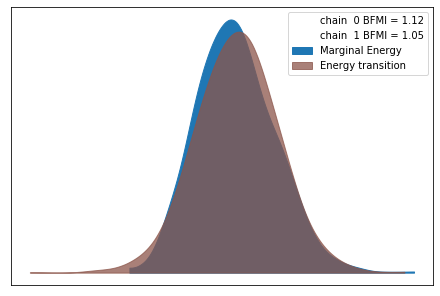

In [37]:
pm.energyplot(trace);

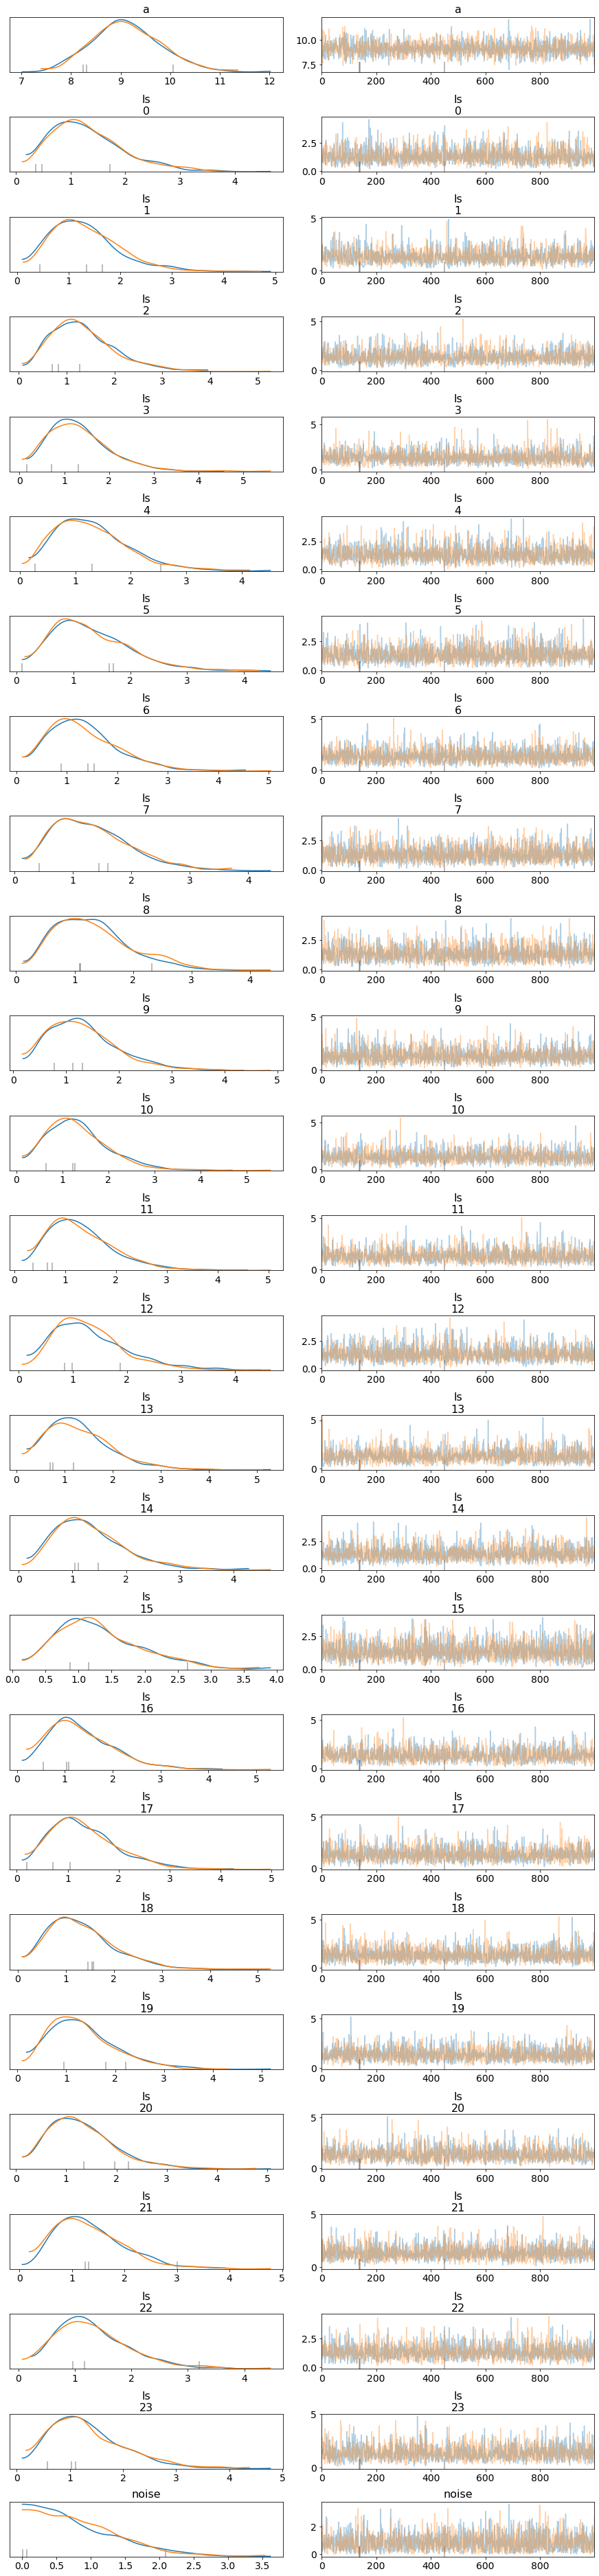

In [38]:
pm.traceplot(trace);

In [45]:
with model:
    # ppc = pm.sample_posterior_predictive(trace, samples=10000)
    f_pred = gp.conditional('x_pred', x_star)
    f_star = pm.sample_posterior_predictive(trace
                                             , vars=[f_pred]
                                             , samples=10000) 


100%|██████████| 1000/1000 [00:12<00:00, 79.24it/s]


In [46]:
samples = f_star['x_pred']

print(samples.shape)
print(samples)
# ppc['obs'].mean(axis=1)

(1000, 100)
[[61.68891914 54.73438776 52.15945034 ... 44.98400656 63.94278602
  46.77482013]
 [44.06520451 63.70401453 40.62658401 ... 53.17836516 59.3439973
  59.85498309]
 [49.64720056 61.74047988 62.57686109 ... 66.48256602 55.68713993
  48.53677747]
 ...
 [53.86110483 39.10791006 34.0174042  ... 63.44664137 64.53389462
  67.0287111 ]
 [39.58317025 40.36262618 55.26889887 ... 48.3032153  61.1345446
  45.65123856]
 [54.74921536 54.85079464 41.33685901 ... 47.14125266 54.85731795
  46.76123577]]


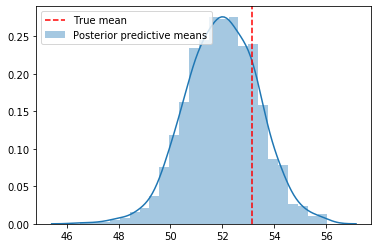

In [50]:
fig, ax = plt.subplots()
sns.distplot(samples.mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(y_star.mean(), ls='--', color='r', label='True mean')
ax.legend(); 

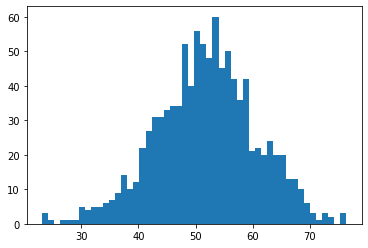

In [48]:
samples_0 = samples[:,0]

fig, ax = plt.subplots()
ax.hist(samples_0, bins=50);

In [51]:
print(y_star[0])
print(samples_0.shape)
print(samples_0.mean())

43
(1000,)
51.81520635786108


# Fit a GP (GPyTorch)

In [55]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=train_x.shape[1])
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [61]:
train_x = torch.from_numpy(x).double()
train_y = torch.from_numpy(y).double()
test_x = torch.from_numpy(x_star).double()
test_y = torch.from_numpy(y_star).double()


In [62]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)
train_x = train_x.cuda()
train_y = train_y.cuda()
test_x = test_x.cuda()
test_y = test_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

In [63]:
# Find optimal model hyperparameters
model.double()
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 1000
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i%(training_iter/10)==0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()), end='\r')
    optimizer.step()

Iter 1/1000 - Loss: 148.783Iter 101/1000 - Loss: 42.460Iter 201/1000 - Loss: 31.902Iter 301/1000 - Loss: 26.665Iter 401/1000 - Loss: 23.380Iter 501/1000 - Loss: 21.308Iter 601/1000 - Loss: 19.326Iter 701/1000 - Loss: 18.423Iter 801/1000 - Loss: 17.188Iter 901/1000 - Loss: 16.306

In [64]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ppc = likelihood(model(test_x))
    print(ppc.mean.cpu().numpy())
    samples = ppc.sample(sample_shape=torch.Size([10000,])).cpu().numpy()
    print(samples.shape)


[-5.77453244  3.51414119  5.2373692  -4.81471102 -0.70434079  2.05285996
 -2.40587005  2.50471216  1.31373827  0.53420585 -4.98381409  1.06409945
 -1.34729139 -2.45353744  5.02685608 -1.04714269 -0.70734663 -3.8911831
 -2.37421891 -1.67627284 -0.49998244  5.94271104 -0.74099693  0.25681844
 -3.06391956 -0.66337142  1.62128276  4.01286488 -2.12689998  2.34158763
 -2.04596979 -0.57119457  0.22563648 -3.44185064  4.27820982  3.02956073
  4.22079446  2.82414695  0.12045323 -0.82856621 -8.69788485  0.39430091
  6.09657873  1.44658948 -4.15659284 -3.40393448  0.16522062  4.10282532
 -1.71357286 -0.45534043  0.35323906  1.03288194 -2.86494861  2.90702238
 -1.50455628 -3.33660698  0.28099581  3.3399552  -6.21493581  5.76978868
 -1.57665995 -1.47571133  4.92126204  5.61152144  0.66019581 -3.81473491
 -8.61088553  0.22403656  2.81632605 -0.57378878  2.01573563 -0.75475768
  0.34400531 -3.95762004  1.52317708 -0.44276497 -6.75305173 -1.80824605
 -0.48691765 -5.82670844 -4.9147428  -1.67474287  0.

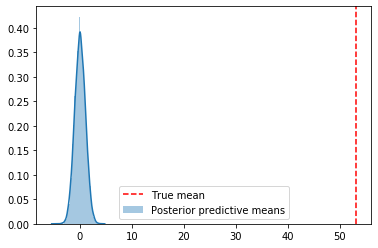

In [66]:
fig, ax = plt.subplots()
sns.distplot(samples.mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(test_y.mean(), ls='--', color='r', label='True mean')
ax.legend(); 


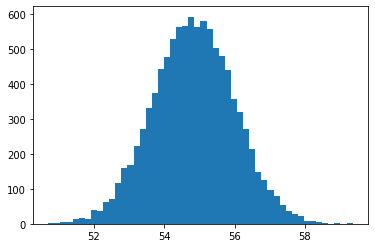

In [53]:
samples_0 = samples[:,0]

fig, ax = plt.subplots()
ax.hist(samples_0, bins=50);

In [54]:
print(y[0])
print(samples_0.shape)
print(samples_0.mean())

59
(10000,)
54.82976695929272
